In [2]:
#imports 

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import models, transforms

import os
from PIL import Image
import matplotlib.pyplot as plt
import random


In [3]:
# PATHS
DATA_PATH = os.path.join(os.getcwd(),"data")
INPUT_DATA_PATH = os.path.join(DATA_PATH,"input")
OUTPUT_DATA_PATH = os.path.join(DATA_PATH,"output")
MODELS_PATH = os.environ.get("MODEL_PATH")

os.makedirs(INPUT_DATA_PATH,exist_ok=True)
os.makedirs(OUTPUT_DATA_PATH,exist_ok=True)

IMAGENET_MEAN=torch.tensor([0.485, 0.456, 0.406])
IMAGENET_STD=torch.tensor([0.229, 0.224, 0.225])

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
os.environ['TORCH_HOME'] = MODELS_PATH
model = models.vgg16().features.eval()


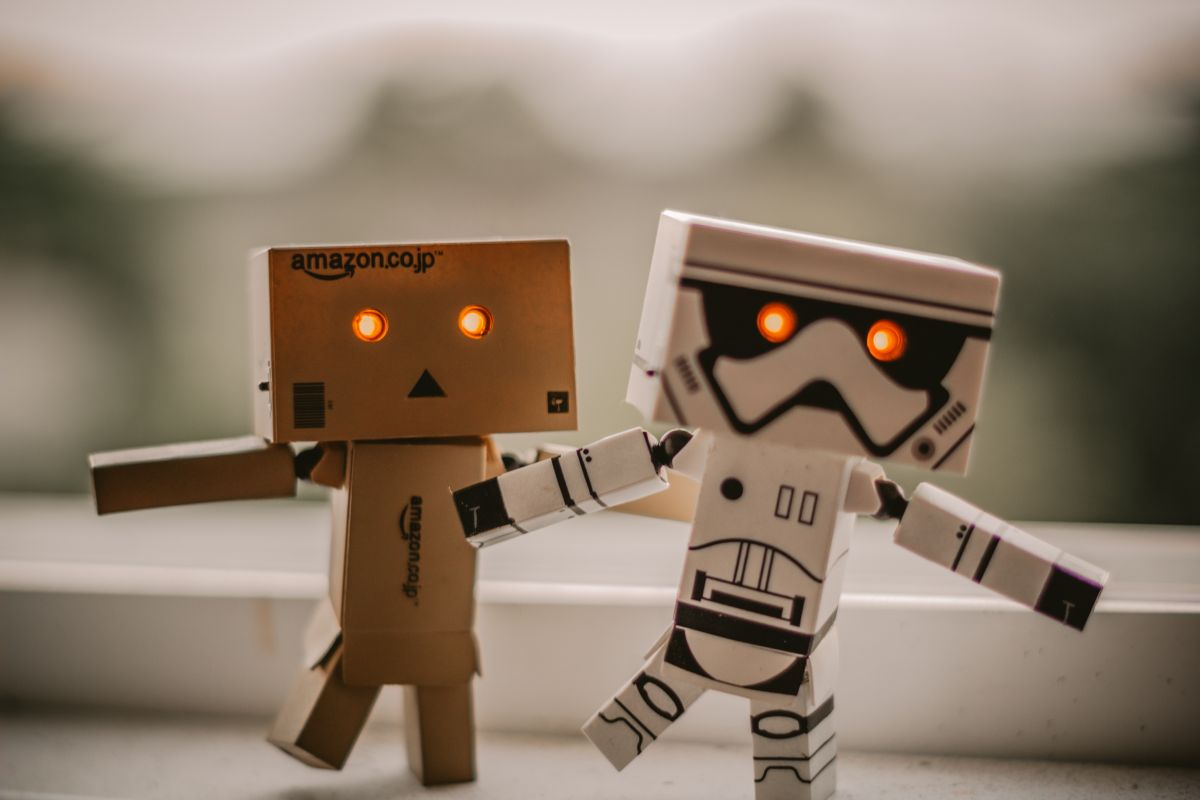

In [5]:
image_path= INPUT_DATA_PATH+"/logo.jpeg"
Image.open(image_path).convert('RGB')

In [115]:
def preprocess_image(image_path):   
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((700, 700)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])
    return transform(image)



image = preprocess_image(image_path)
# Deep copy the image
original_image = image.clone()

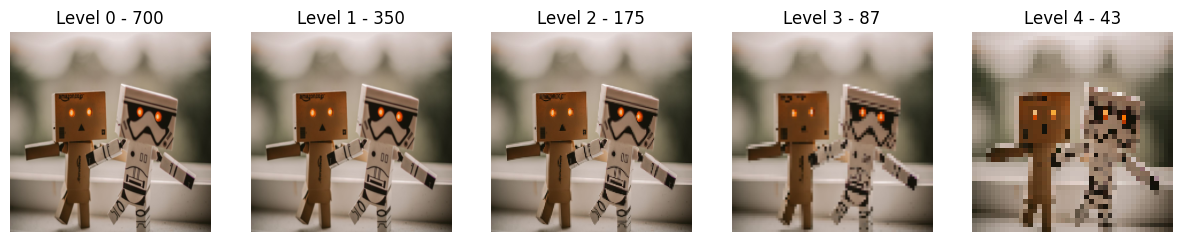

In [116]:
def create_image_pyramid(image, num_levels=5):
    image = image.unsqueeze(0)
    pyramid = [image]
    for i in range(1, num_levels):
        scaled_image = torch.nn.functional.interpolate(
            image, scale_factor=1/(2**i), mode='bilinear', align_corners=False
        )
        pyramid.append(scaled_image)
    return pyramid

def d_normalize(image,mean= IMAGENET_MEAN, std= IMAGENET_STD):
    return image * std.view(3,1,1) + mean.view(3,1,1)

# Display the image pyramid
def show_image_pyramid(pyramid):
    num_levels = len(pyramid)
    fig, axes = plt.subplots(1, num_levels, figsize=(15, 5))
    
    for i, img in enumerate(pyramid):
        img = d_normalize(img).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Convert tensor to image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Level {i} - {img.shape[-2]}')
    
    plt.show()

show_image_pyramid(create_image_pyramid(image,num_levels=5))

In [119]:

lr = 0.01
image = image.requires_grad_()  # Ensure image has gradients
optimizer = torch.optim.AdamW([image], lr=lr)

steps = 100
layers_to_maximize = [11,20,22, 25, 27,29]  # Layers where we want to maximize activation
num_levels = 5

model = model.to(device)

# DeepDream function
def deepdream(steps, image, layers_to_maximize, num_levels,lr=0.3):
    for step in range(steps):

        # Create image pyramid
        pyramid = create_image_pyramid(image, num_levels=num_levels)
        losses = []
        # Iterate over pyramid levels
        for pyramid_image in pyramid:
            x = pyramid_image.to(device)
            
            # Forward pass through model layers
            for i, layer in enumerate(model):
                x = layer(x)
                if i in layers_to_maximize:
                    loss = nn.MSELoss(reduction="mean")(x, torch.zeros_like(x))
                    losses.append(loss)
            loss = torch.mean(torch.stack(losses))
            loss.backward()  # Perform gradient ascent

        grad = image.grad.data
        smooth_grad = transforms.functional.gaussian_blur(grad,kernel_size=random.choice([5,7,9,11]),sigma=random.random()+.5)
        
        # Normalize the gradients (make them have mean = 0 and std = 1)
        # I didn't notice any big difference normalizing the mean as well - feel free to experiment
        g_std = torch.std(smooth_grad)
        g_mean = torch.mean(smooth_grad)
        smooth_grad = smooth_grad - g_mean
        smooth_grad = smooth_grad / g_std
        
        image.data += lr * smooth_grad
        image.grad.data.zero_()
        
        
        if step % 25== 0:
            print(f"Step {step}, Loss: {loss.item()}")

    return image

# Run the DeepDream function
dream_image = deepdream(steps, image, layers_to_maximize, num_levels)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
def deprocess(tensor):
    tensor = tensor.squeeze().detach().cpu()
    tensor = tensor * IMAGENET_STD.view(3, 1, 1)
    tensor = tensor + IMAGENET_MEAN.view(3, 1, 1)
    tensor = tensor.clamp(0, 1)
    return transforms.ToPILImage()(tensor)
deprocess(dream_image)